In [41]:
import convexgating as cg
import scanpy as sc
import anndata as ann
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import os
from matplotlib.path import Path
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import re

def add_tight_hull_hierarchy(base_df,hierarchy,meta_info,run_ID):
    #base_df = meta_info['general_summary'][run_ID]
    #run_ID - z.B 0
    #meta_info -> .npy output
    #run_ID -> e.g. 0
    marker = meta_info['gating_summary'][run_ID][1][hierarchy]['marker_combo']
    marker1 = marker[0]
    marker2 = marker[1]
    base_df['gate_hull_0'] = base_df['final_gate_0'].copy().astype(int)
    targets_in_gate = base_df[(base_df['final_gate_' +hierarchy] == 1)&(base_df['true_label'] == 1)][[marker1,marker2]].values
    hull = ConvexHull(targets_in_gate)
    edge_points_indices = hull.vertices
    hull_path = Path(targets_in_gate[hull.vertices])
    final_hull = [hull_path.contains_point(point) for point in base_df[[marker1,marker2]].values]*1
    base_df['hull_' + hierarchy] = [int(val) for val in final_hull]
    base_df['hull_' + hierarchy] = [int(val) for val in final_hull]
    return base_df

def add_gate_tight(base_df,meta_info,run_ID):
    column_numbers = [int(re.findall(r'^final_gate_(\d+)$', col)[0]) for col in base_df.columns if re.match(r'^final_gate_\d+$', col)]

    total_hierarchies = np.max(column_numbers)

    for h in range(1,total_hierarchies+1):
        base_df = add_tight_hull_hierarchy(base_df,str(h),meta_info = meta_info,run_ID=run_ID)

    base_df['gate_hull_1'] = base_df['hull_1'].copy()
    if total_hierarchies>1:
        for hc in range(2,total_hierarchies+1):
            base_df['gate_hull_' +str(hc)] = base_df['gate_hull_' +str(hc -1)]*base_df['hull_'+str(hc)]
    return base_df

def add_tight_metric(base_df,path_to_save_performance):
    column_numbers = [int(re.findall(r'^final_gate_(\d+)$', col)[0]) for col in base_df.columns if re.match(r'^final_gate_\d+$', col)]
    total_hierarchies = np.max(column_numbers)
    f1_rec_prec_out = pd.DataFrame(index=["f1", "recall", "precision"])
    for hier in range(1, total_hierarchies + 1):
        g_string = "gate_hull_" + str(hier)
        h_string = "hierarchy_" + str(hier)
        f, r, p = (
            np.round(f1_score(base_df["true_label"].values, base_df[g_string].values), 6),
            np.round(recall_score(base_df["true_label"].values, base_df[g_string].values), 6),
            np.round(precision_score(base_df["true_label"].values, base_df[g_string].values), 6),
        )
        f1_rec_prec_out[h_string] = f, r, p
        
    save_location = os.path.join(path_to_save_performance, "performance.csv")
    f1_rec_prec_out.to_csv(save_location)
    
def add_visualization_hierarchy(meta_info,base_df,save_location,hierarchy,run_ID,
                                gate_color = 'r',
                                targets_color = '#F06105',
                                non_targets_color = 'CornflowerBlue',
                                save = True,
                                show=True):
    population = meta_info['clusterkeys'][run_ID]
    marker = meta_info['gating_summary'][run_ID][1][hierarchy]['marker_combo']
    marker1 = marker[0]
    marker2 = marker[1]

    points_df = base_df[base_df['gate_hull_' + str(int(hierarchy)-1)] == 1]


    in_gate_target = base_df[(base_df['gate_hull_' + hierarchy]==1)&(base_df['true_label']==1)]


    in_gate_target_points = in_gate_target[[marker1,marker2]].values

    hull = ConvexHull(in_gate_target_points)

    edge_points_indices = hull.vertices

    edge_points = in_gate_target_points[edge_points_indices]

    color_map = {0: non_targets_color, 1: targets_color}



    plt.figure(figsize=(6, 4))
    plt.scatter(points_df[marker1].values, points_df[marker2].values, c=points_df['true_label'].map(color_map),alpha = 0.4,s=10)
    for simplex in hull.simplices:
        plt.plot(in_gate_target_points[simplex, 0], in_gate_target_points[simplex, 1], color=gate_color,alpha = 0.6,linewidth = 2.5)
    plt.tight_layout()
    plt.xlabel(marker1,fontsize = 11)
    plt.ylabel(marker2,fontsize = 11)
    plt.title('cluster ' + population +' - hierarchy ' + hierarchy,fontsize = 12)
    if save:
        save_ID = 'cluster_' + population + '_hierarchy_' + hierarchy + '.pdf'
        save_path = os.path.join(save_location, save_ID)
        plt.savefig(save_path,bbox_inches='tight')
    if show:
        plt.show()
    plt.close()
    return edge_points

def add_tight_analysis(meta_info,run_ID,save_loc):
    if not os.path.exists(save_loc):
        os.mkdir(save_loc)

    base_df = meta_info['general_summary'][run_ID]
    base_df = add_gate_tight(base_df,meta_info,run_ID)
    add_tight_metric(base_df = base_df,
                     path_to_save_performance = save_loc)



    column_numbers = [int(re.findall(r'^final_gate_(\d+)$', col)[0]) for col in base_df.columns if re.match(r'^final_gate_\d+$', col)]
    total_hierarchies = np.max(column_numbers)
    for hierarchy in range(1,total_hierarchies+1):
        edge_points = add_visualization_hierarchy(meta_info = meta_info,
                                base_df = base_df,
                                save_location = save_loc,
                                hierarchy = str(hierarchy),
                               run_ID = run_ID)
        edge_save_loc = os.path.join(save_loc,'cluster_' + population + '_gate_edges_hierarchy_' + str(hierarchy))
        pd.DataFrame(edge_points,columns = ['x_coordinate','y_coordinate']).to_csv(edge_save_loc)

# Infos
meta info['clusterkeys'],
meta_info['general_summary']


In [42]:
save_loc = '62_02_cluster_C26'
meta_info = np.load('02_C26_meta_info.npy',allow_pickle=True).item()
run_ID =0

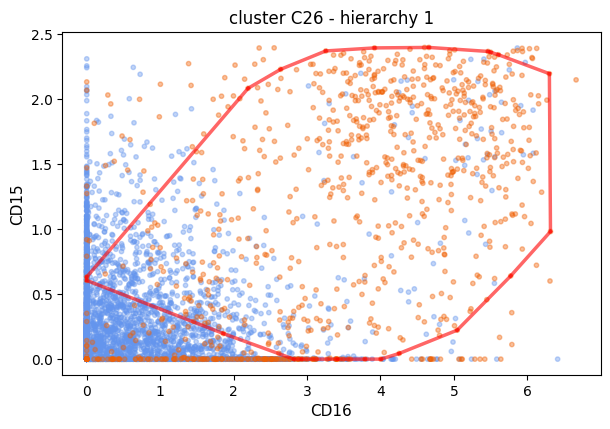

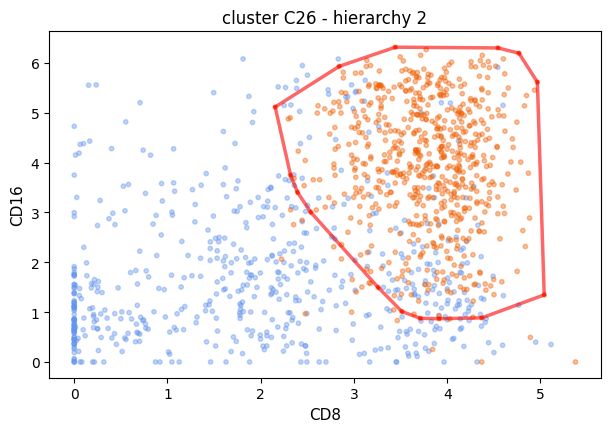

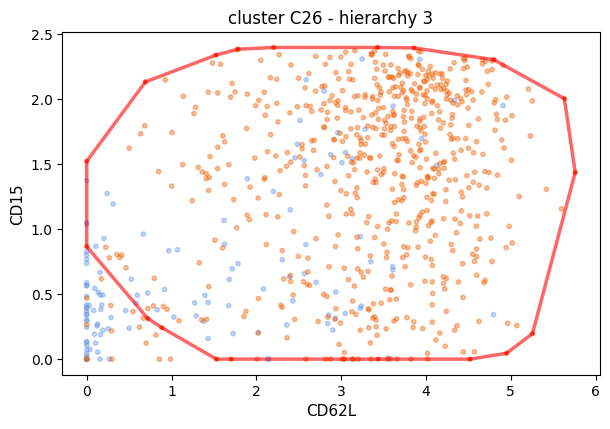

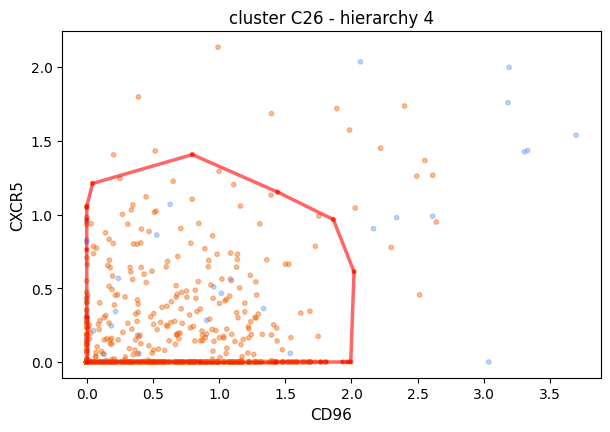

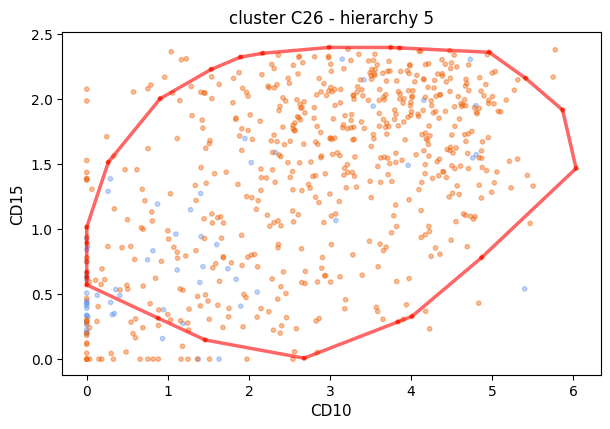

In [43]:
add_tight_analysis(meta_info,run_ID,save_loc)

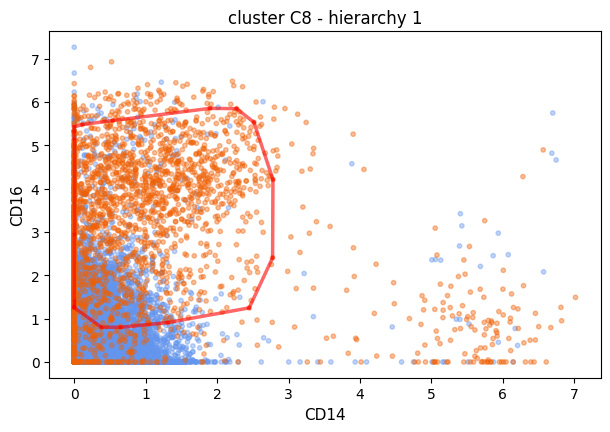

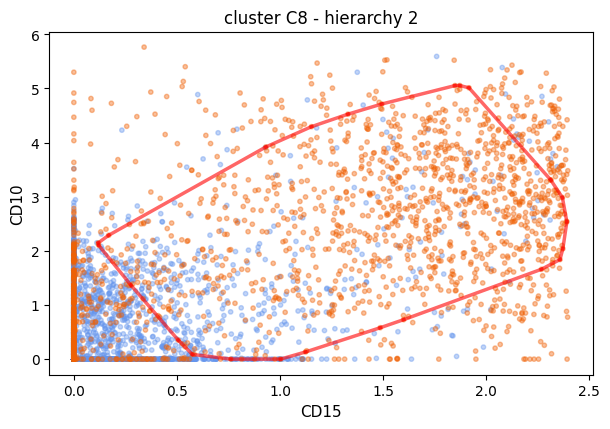

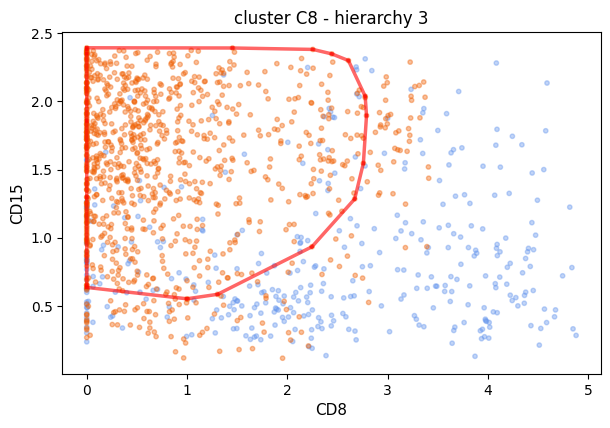

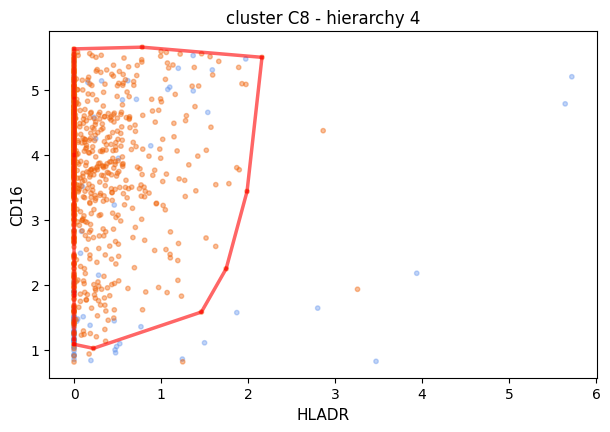

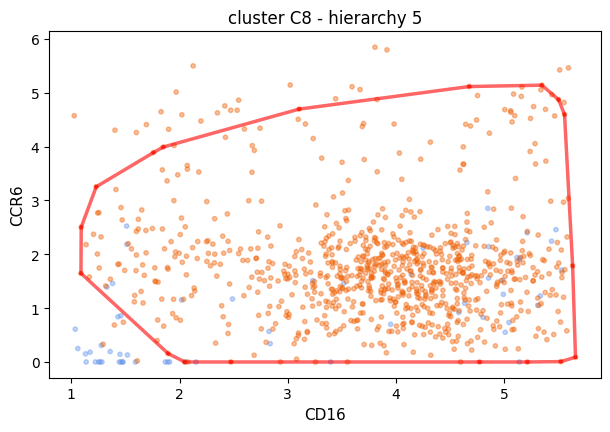

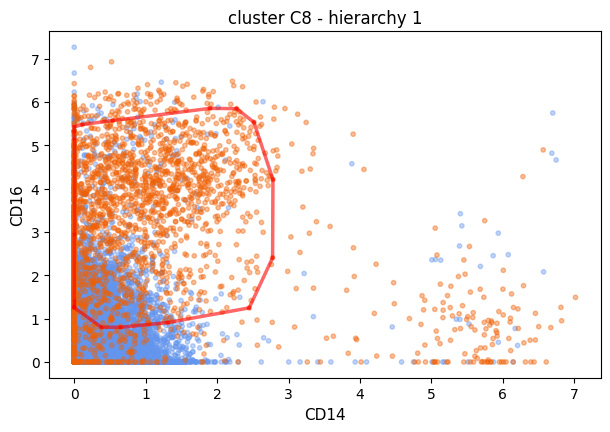

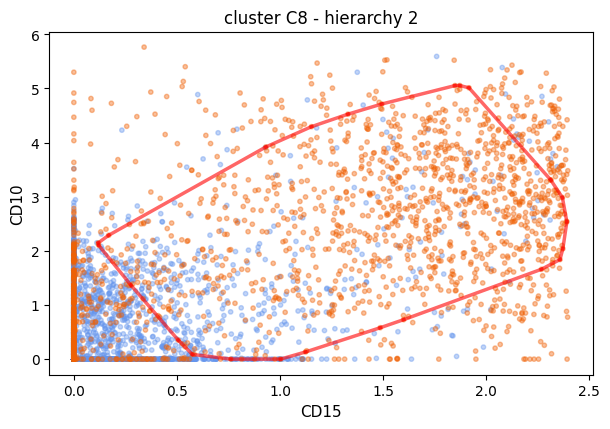

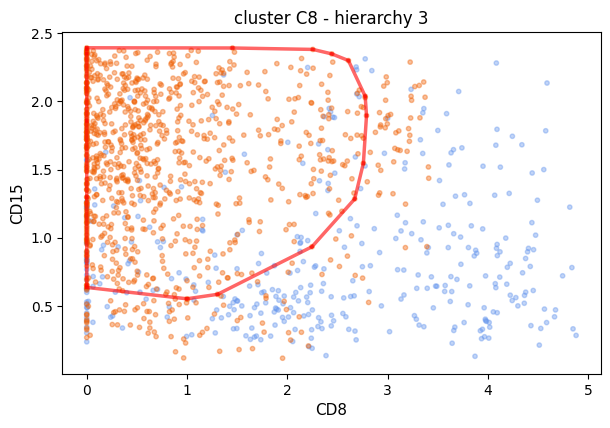

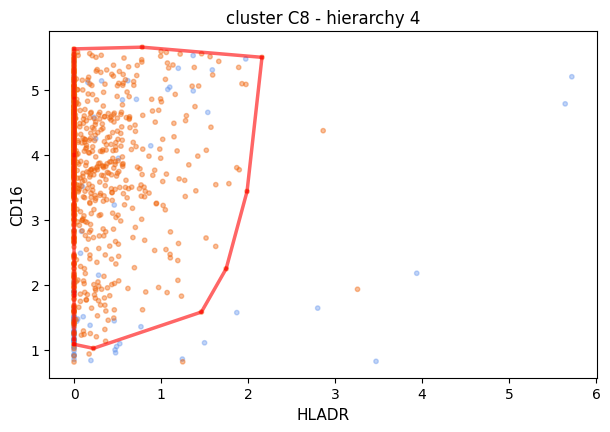

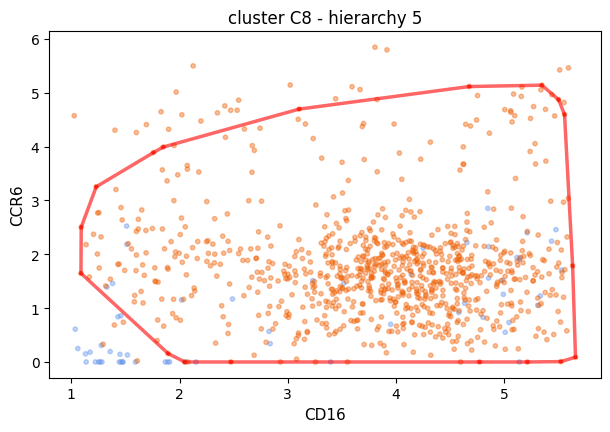

In [18]:
save_path = os.path.join(save_location, save_ID)

5

In [32]:
population = 'test'

In [33]:
edge_save_loc = os.path.join(save_loc,'cluster_' + population + '_gate_edges_hierarchy_' + str(hierarchy))

In [34]:
pd.DataFrame(edge_points,columns = ['x_coordinate','y_coordinate']).to_csv(edge_save_loc)

In [ ]:
for q in range(3):
    array 